### Business otázky
vytvořit systém "objektivního" skórování, který umožňuje efektivněji porovnat hotely na základě těchto otázek  
* jaký je vztah sentimentu a skóre?
* jaký vliv má národnost na výsledné skóre
* jaký vliv mají tagy na skóre
* jaký vliv má počet hodnocení na skóre

### Datasety
**Hotel_Reviews.csv** původní nezměněný dataset  
**Hotel_Reviews_pp5.csv** vyvážený dataset podle národností a omezen na 17k řádků, vytvořené features podle tagů, sentiment pro každé hodnocení


In [ ]:
import pandas as pd
import spacy
import seaborn as sns
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import plotly.express as px

import ast

from sklearn import metrics 
import numpy as np 

In [ ]:
hotel = pd.read_csv("Hotel_Reviews.csv")
hotel_pp = pd.read_csv("Hotel_Reviews_pp5.csv")

drop columns with missing values and reset index

### Vizualizace

#### popisná statistika
uvnitř v souboru report.html

In [ ]:
ProfileReport(hotel).to_file("report.html")
ProfileReport(hotel_pp).to_file("report_pp.html")

#### korelační matice

* počet slov v negativním hodnocení koreluje s výsledným skóre (spokojení zákazníci jsou struční v negativním hodnocení)
* naopak velmi mírná st. závislost mezi počtem slov v pozitivním hodnocení a výsledným skóre 
* můžeme vidět pozitivní korelaci (0.55) mezi skóre a sentimentem
* počet strávených nocí ani to, že byl příspěvek přidán z mobilu nemá vliv na skóre


<AxesSubplot:>

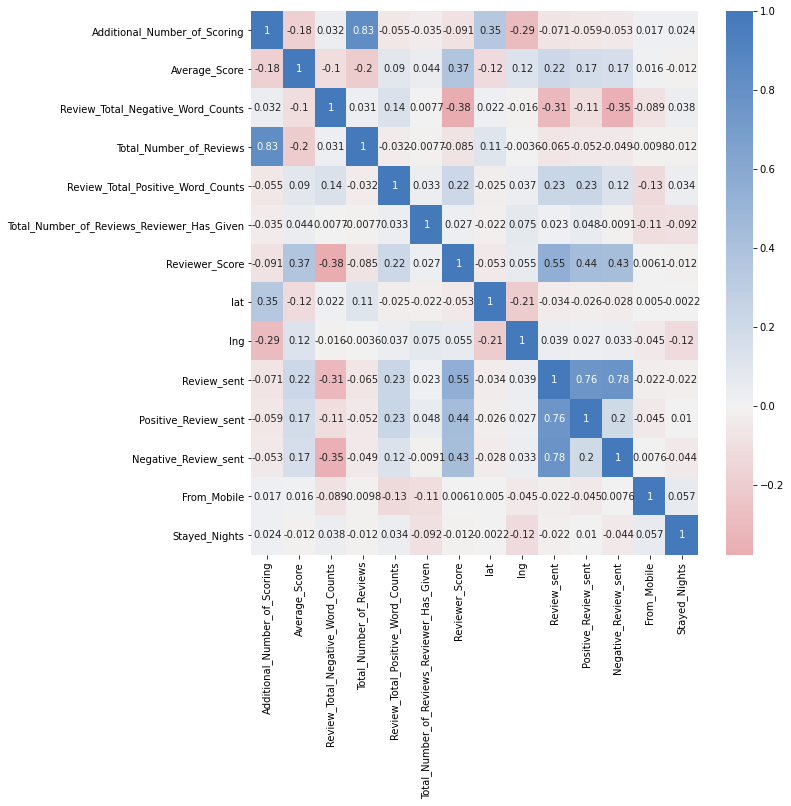

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(hotel_pp.corr(), annot=True, cmap=sns.diverging_palette(10, 250, as_cmap=True), center=0)

#### histogram skóre

<AxesSubplot:xlabel='Reviewer_Score', ylabel='Count'>

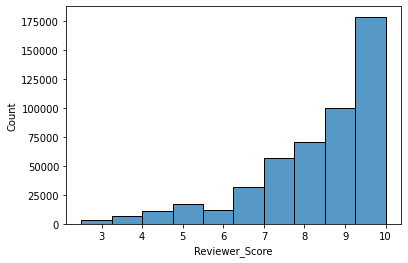

In [ ]:
sns.histplot(x='Reviewer_Score', data=hotel, bins=10)

#### top # recenzentu podle národnosti (relativní počty)
* velká část recenzentů z UK

<AxesSubplot:xlabel='relative_counts', ylabel='Reviewer_Nationality'>

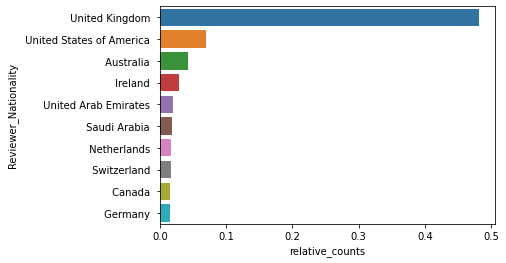

In [ ]:
top_n = 10
reviewers_counts = pd.DataFrame(hotel.groupby('Reviewer_Nationality')['Hotel_Name'].count().sort_values(ascending=False))
reviewers_counts.columns = ['counts']
top_reviewers = reviewers_counts[:top_n] # get top n
top_reviewers = top_reviewers.reset_index()
top_reviewers['relative_counts'] = top_reviewers['counts'] / hotel.shape[0]

sns.barplot(x='relative_counts', y='Reviewer_Nationality', data=top_reviewers)

#### top # hotelů podle průměrného skóre

In [ ]:
hotel_unique = hotel.drop_duplicates('Hotel_Name')
hotel_top_avg = hotel_unique.sort_values(by='Average_Score', ascending=False).reset_index()[:top_n]
hotel_top_avg[['Hotel_Name', 'Average_Score']]

,Hotel_Name,Average_Score
0,Ritz Paris,9.8
1,Hotel The Serras,9.6
2,Haymarket Hotel,9.6
3,41,9.6
4,H tel de La Tamise Esprit de France,9.6
5,H10 Casa Mimosa 4 Sup,9.6
6,Hotel Casa Camper,9.6
7,Hotel Sacher Wien,9.5
8,Ham Yard Hotel,9.5
9,Charlotte Street Hotel,9.5


#### národnosti podle průměrného skóre
*národnosti s alespoň 1000 hodnoceními*

In [ ]:
counts = pd.DataFrame(hotel['Reviewer_Nationality'].value_counts())
nationalities = counts[counts['Reviewer_Nationality'] > 1000].index # countries with at least # reviews
hotel_sub = hotel[hotel['Reviewer_Nationality'].isin(nationalities)]
# sorted by mean
nat_avgs = hotel_sub.groupby('Reviewer_Nationality')['Reviewer_Score'].mean().sort_values().reset_index() #['Reviewer_Nationality']
nat_avgs

,Reviewer_Nationality,Reviewer_Score
0,Oman,7.836962
1,India,7.874418
2,Saudi Arabia,7.887685
3,United Arab Emirates,7.888392
4,Qatar,7.899390
5,Bahrain,7.939974
6,Lebanon,7.995227
7,Turkey,8.005301
8,Kuwait,8.008186
9,Hong Kong,8.019580


### business case

* cestující za prací jsou v hodnocení kritičtější

<AxesSubplot:xlabel='Reviewer_Score', ylabel='Travel_type'>

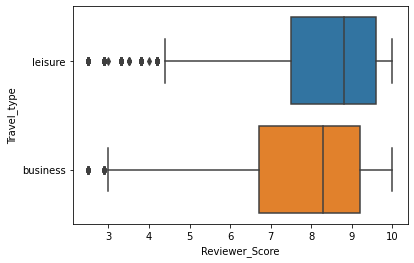

In [ ]:
sns.boxplot(y='Travel_type',x='Reviewer_Score',data=hotel_pp)

* jedinci mají tendenci dávat nižší hodnocení než skupiny (rodina, skupina, pár)

<AxesSubplot:xlabel='Reviewer_Score', ylabel='N_Persons'>

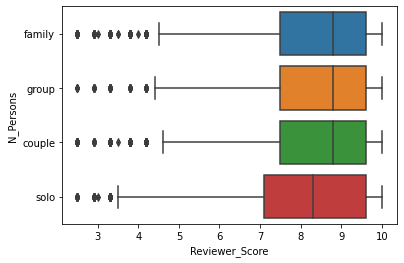

In [ ]:
sns.boxplot(y='N_Persons',x='Reviewer_Score',data=hotel_pp)

* velké množství pozitivních hodnocení má téměř neutrální sentiment

Text(0.5, 1.0, 'Skóre vs. sentiment')

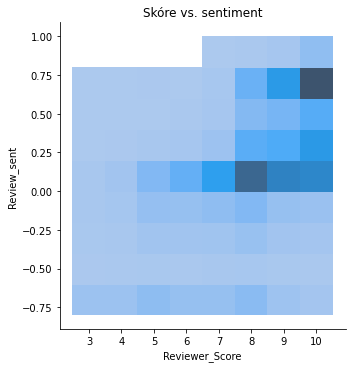

In [ ]:
sns.displot(hotel_pp, y="Review_sent", x="Reviewer_Score", binwidth=(1, 0.2))
plt.title("Skóre vs. sentiment")

### Objektivní skórování
'Objective_Score' = 'Reviewer_Score' \* 'Nat_factor' \* 'Type_factor' \* 'N_Pers_factor'

In [ ]:
def get_factors(cat_variable):
    mean_ratings = hotel_pp.groupby(cat_variable)['Reviewer_Score'].mean().sort_values()
    return mean_ratings.mean() / mean_ratings

In [ ]:
nat_factors = get_factors('Reviewer_Nationality')
bus_factors = get_factors('Travel_type')
pers_factors = get_factors('N_Persons')

In [ ]:
hotel_pp['Travel_type'].fillna('', inplace=True)
for i,row in hotel_pp.iterrows():
    hotel_pp.loc[i, 'Nat_factor'] = nat_factors[row['Reviewer_Nationality']]
    hotel_pp.loc[i, 'Type_factor'] = bus_factors[row['Travel_type']] if row['Travel_type'] != '' else 1
    hotel_pp.loc[i, 'N_Pers_factor'] = pers_factors[row['N_Persons']]

In [ ]:
hotel_pp['Objective_Score'] = hotel_pp['Reviewer_Score'] * hotel_pp['Nat_factor'] * hotel_pp['Type_factor'] * hotel_pp['N_Pers_factor']

In [ ]:
hotel_pp[['Reviewer_Score', 'Objective_Score']]

,Reviewer_Score,Objective_Score
0,8.3,7.921018
1,7.9,7.432861
2,4.6,4.389962
3,8.8,8.215800
4,5.8,5.457037
...,...,...
16995,9.6,9.046219
16996,6.7,6.975983
16997,8.3,7.821210
16998,10.0,9.848498


**top 10 hotelů podle objektivního skórování**

In [ ]:
hotels_count = pd.DataFrame(hotel_pp['Hotel_Name'].value_counts())
hotels_40 = hotels_count[hotels_count['Hotel_Name'] > 40].index # with at least 40 reviews
top_10_hotels = pd.DataFrame(hotel_pp[hotel_pp['Hotel_Name'].isin(hotels_40)].groupby('Hotel_Name')[['Objective_Score', 'Reviewer_Score']].mean().sort_values(by='Objective_Score', ascending=False)[:10])
top_10_hotels.reset_index()

,Hotel_Name,Objective_Score,Reviewer_Score
0,Jaz Amsterdam,9.109970,9.270588
1,citizenM Tower of London,8.884023,9.018519
2,The Montcalm Marble Arch,8.834066,8.726829
3,Hotel Berna,8.785042,9.053191
4,25hours Hotel beim MuseumsQuartier,8.733926,8.893333
5,Eurostars Grand Marina Hotel GL,8.713430,8.816981
6,The Square Milano Duomo,8.708402,8.855932
7,Austria Trend Hotel Savoyen Vienna,8.703908,8.864444
8,citizenM London Bankside,8.692431,8.748148
9,Urban Lodge Hotel,8.688922,8.842593


# ANALÝZA NÁRODNOSTI

In [ ]:
top_n = 34
reviewers_counts = pd.DataFrame(hotel.groupby('Reviewer_Nationality')['Hotel_Name'].count().sort_values(ascending=False))
reviewers_counts.columns = ['counts']
top_reviewers = reviewers_counts[:top_n] # get top n
top_reviewers = top_reviewers.reset_index()
top_reviewers['relative_counts'] = top_reviewers['counts'] / hotel.shape[0]

#plt.figure(figsize=(10, 10))
#sns.barplot(x='relative_counts', y='Reviewer_Nationality', data=top_reviewers
#);
#plt.title("Národnosti recenzentů na celém nevyváženém datasetu",fontsize = 20, pad=20) 
#plt.show();

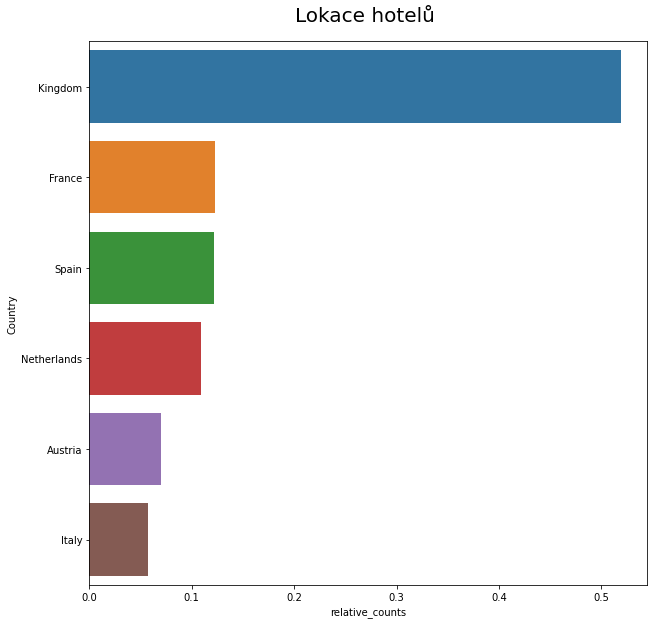

In [ ]:
hotels_sarka = hotel
hotels_sarka['Country']=hotels_sarka['Hotel_Address'].apply(lambda x: x.split()[-1])
country_counts = pd.DataFrame(hotels_sarka.groupby('Country')['Hotel_Name'].count().sort_values(ascending=False))
country_counts.columns = ['counts']
top_country = country_counts[:top_n] # get top n
top_country = top_country.reset_index()
top_country['relative_counts'] = top_country['counts'] / hotels_sarka.shape[0]

plt.figure(figsize=(10, 10))
plt.title("Lokace hotelů ",fontsize = 20, pad=20) 

sns.barplot(x='relative_counts', y='Country', data=top_country 
);

plt.show();

In [ ]:
nationality = hotel.loc[hotel.Reviewer_Nationality.isin(hotel_pp.Reviewer_Nationality)]
nationality = nationality.groupby(['Hotel_Name'], as_index=False)['Reviewer_Nationality', 'Positive_Review', 'Reviewer_Score'].aggregate(
    {'Reviewer_Nationality':'nunique','Positive_Review':'count','Reviewer_Score':'mean'})
nationality = nationality.rename(columns={"Positive_Review": "Reviews"})
nationality = nationality.sort_values('Reviewer_Nationality',ascending=False).iloc[:top_n].reset_index(drop=True)


/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


**Vyvážení dat přes top národy a hotely, u kterých měly renceze všechny top národnosti**

In [ ]:
hotel_an = hotel.loc[hotel.Hotel_Name.isin(nationality.Hotel_Name)]
hotel_an = hotel_an.loc[hotel.Reviewer_Nationality.isin(hotel_pp.Reviewer_Nationality)].reset_index(drop=True) #hotely, u kterych recenzovaly všechny top národnosti
hotel_an = hotel_an[['Hotel_Name','Reviewer_Nationality', 'Positive_Review', 'Reviewer_Score']]
hotel_an = hotel_an.groupby(['Hotel_Name','Reviewer_Nationality'], as_index=False).aggregate(
    {'Positive_Review':'count','Reviewer_Score':'mean'})

In [ ]:
seznam = hotel_an.groupby('Reviewer_Nationality',as_index=False)['Reviewer_Score'].mean().sort_values('Reviewer_Score')
#seznam['Reviewer_Nationality'].to_list()

In [ ]:
pivot_n_h = hotel_an.pivot_table(index='Hotel_Name',
                     columns='Reviewer_Nationality',
                     values='Reviewer_Score')

In [ ]:
pivot_n_h = pivot_n_h.reindex([' Kuwait ',
 ' United Arab Emirates ',
 ' Saudi Arabia ',
 ' Lebanon ',
 ' Qatar ',
 ' Belgium ',
 ' Turkey ',
 ' Poland ',
 ' Switzerland ',
 ' India ',
 ' Sweden ',
 ' Netherlands ',
 ' France ',
 ' Hong Kong ',
 ' Greece ',
 ' Germany ',
 ' Norway ',
 ' Romania ',
 ' Singapore ',
 ' Spain ',
 ' Italy ',
 ' Egypt ',
 ' Czech Republic ',
 ' Russia ',
 ' China ',
 ' South Africa ',
 ' Australia ',
 ' Austria ',
 ' Ireland ',
 ' Canada ',
 ' United Kingdom ',
 ' United States of America ',
 ' Israel ',
 ' New Zealand '], axis=1)

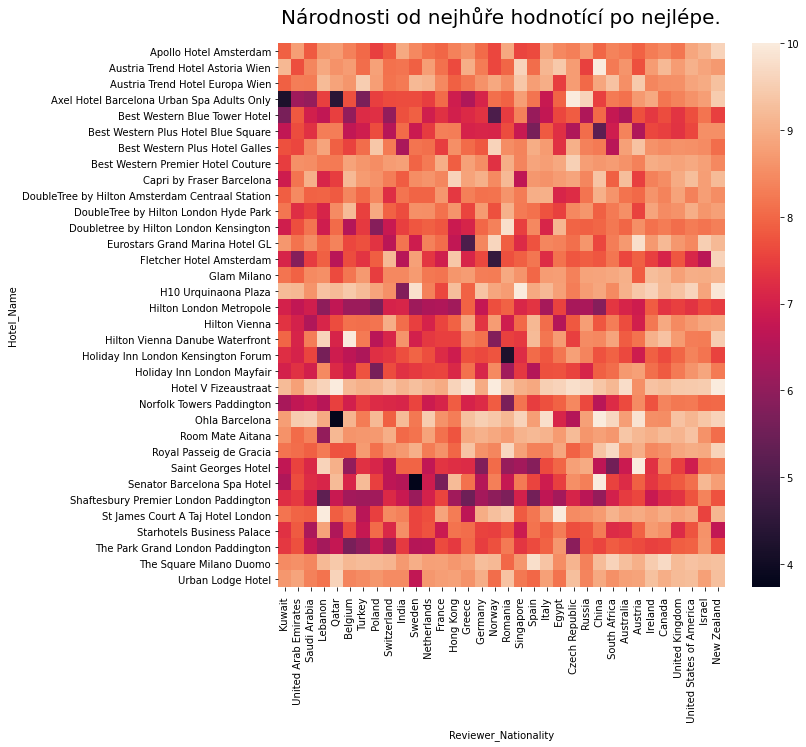

In [ ]:
plt.figure(figsize=(10, 10))


ax = plt.axes()
sns.heatmap(pivot_n_h, ax = ax)

ax.set_title('Národnosti od nejhůře hodnotící po nejlépe.' , fontsize = 20, pad=20)
plt.show()

- Data pro heatmapu byla vyvážena tak, že každý zobrazený hotel byl hodnocen všemi zkoumanými národnostmi. 
- Národnosti jsou seřazeny od v průměru hořšího hodnocení hotelů k pozitivnějšímu hodnocení hotelů.

In [ ]:
region = {"Africa":['Algeria','Angola','Benin','Botswana','Burkina','Burundi','Cameroon','Cape Verde','Central African Republic','Chad','Comoros','Congo','Congo, Democratic Republic of','Djibouti','Egypt','Equatorial Guinea','Eritrea','Ethiopia','Gabon','Gambia','Ghana','Guinea','Guinea-Bissau','Ivory Coast','Kenya','Lesotho','Liberia','Libya','Madagascar','Malawi','Mali','Mauritania','Mauritius','Morocco','Mozambique','Namibia','Niger','Nigeria','Rwanda','Sao Tome and Principe','Senegal','Seychelles','Sierra Leone','Somalia','South Africa','South Sudan','Sudan','Swaziland','Tanzania','Togo','Tunisia','Uganda','Zambia','Zimbabwe'],
    'Asia':['Russia','Afghanistan','Bahrain','Bangladesh','Bhutan','Brunei','Burma (Myanmar)','Cambodia','China','East Timor','India','Indonesia','Iran','Iraq','Israel','Japan','Jordan','Kazakhstan','Korea, North','Korea, South','Kuwait','Kyrgyzstan','Laos','Lebanon','Malaysia','Maldives','Mongolia','Nepal','Oman','Pakistan','Philippines','Qatar','Russian Federation','Saudi Arabia','Singapore','Sri Lanka','Syria','Tajikistan','Thailand','Turkey','Turkmenistan','United Arab Emirates','Uzbekistan','Vietnam','Yemen','Hong Kong'],
    'Europe':['Albania','Andorra','Armenia','Austria','Azerbaijan','Belarus','Belgium','Bosnia and Herzegovina','Bulgaria','Croatia','Cyprus','Czech Republic','Denmark','Estonia','Finland','France','Georgia','Germany','Greece','Hungary','Iceland','Ireland','Italy','Latvia','Liechtenstein','Lithuania','Luxembourg','Macedonia','Malta','Moldova','Monaco','Montenegro','Netherlands','Norway','Poland','Portugal','Romania','San Marino','Serbia','Slovakia','Slovenia','Spain','Sweden','Switzerland','Ukraine','United Kingdom','Vatican City'],
    'North_America':['United States of America','Antigua and Barbuda','Bahamas','Barbados','Belize','Canada','Costa Rica','Cuba','Dominica','Dominican Republic','El Salvador','Grenada','Guatemala','Haiti','Honduras','Jamaica','Mexico','Nicaragua','Panama','Saint Kitts and Nevis','Saint Lucia','Saint Vincent and the Grenadines','Trinidad and Tobago','United States'],
    'South_America':['Argentina','Bolivia','Brazil','Chile','Colombia','Ecuador','Guyana','Paraguay','Peru','Suriname','Uruguay','Venezuela'],
    'Australia_Oceania':['Australia','Fiji','Kiribati','Marshall Islands','Micronesia','Nauru','New Zealand','Palau','Papua New Guinea','Samoa','Solomon Islands','Tonga','Tuvalu','Vanuatu']
}

In [ ]:
df_region = pd.DataFrame(list(region.values()), index=region.keys())
df_region = df_region.T
df_region = pd.melt(df_region)
df_region = df_region.dropna()
df_region = df_region.rename(columns={'variable':'Region', 'value':'Reviewer_Nationality'})


In [ ]:
hotel_reg = hotel_an.groupby('Reviewer_Nationality', as_index=False)['Reviewer_Score'].mean()
hotel_reg['Reviewer_Nationality'] = hotel_reg['Reviewer_Nationality'].str.strip()
hotel_merge = pd.merge(hotel_reg, df_region,on = 'Reviewer_Nationality', how='left').sort_values('Reviewer_Score')


In [ ]:
barvy_regionu = {'Australia_Oceania':'red',
    'Europe':'blue',
    'South_America':'black',
    'North_America':'green',
    'Asia':'yellow',
    'Africa':'orange'
    }

barva = hotel_merge['Region'].map(barvy_regionu)


In [ ]:
hotel_pp.groupby('Reviewer_Nationality',as_index=False)

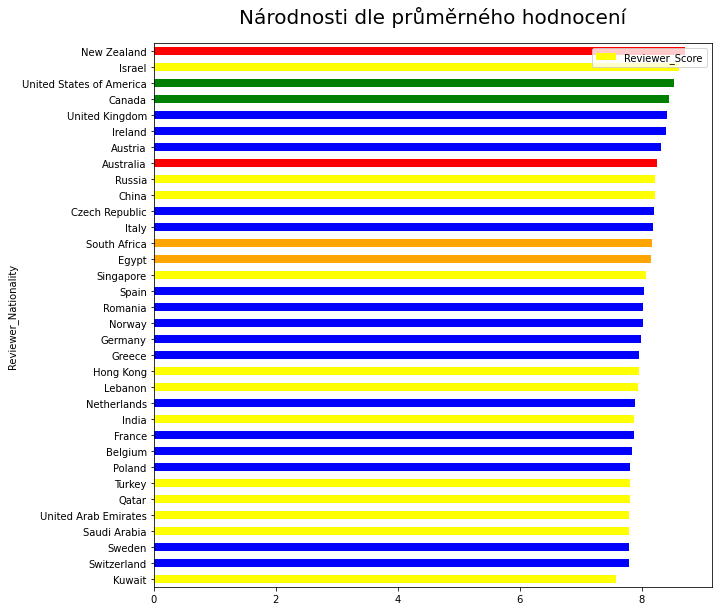

In [ ]:
hotel_merge.plot.barh(
    x='Reviewer_Nationality', y='Reviewer_Score',

    figsize=(10,10),
    color=barva
);

plt.title("Národnosti dle průměrného hodnocení",fontsize = 20, pad=20) 
  
plt.show()  

In [ ]:
hotel_re = hotel.groupby('Reviewer_Nationality', as_index=False)['Reviewer_Score'].mean()
hotel_re['Reviewer_Nationality'] = hotel_re['Reviewer_Nationality'].str.strip()
hotel_merg = pd.merge(hotel_re, df_region,on = 'Reviewer_Nationality', how='left').sort_values('Reviewer_Score')

In [ ]:
hotel_merg=hotel_merg.dropna()

In [ ]:
barva2 = hotel_merge['Region'].map(barvy_regionu)

In [ ]:
color_discrete_map = barvy_regionu
fig = px.box(hotel_merge, x="Region", color="Region",points="all", y="Reviewer_Score",title="Národnosti na vyvážených datech - hodnoceny stejné hotely",  color_discrete_map=color_discrete_map)

fig.update_layout(
xaxis_type = 'category'
)
fig.update_xaxes(categoryorder='category ascending')

- vyvážený dataset nebyl vyvážen přes regiony
- ale z dostatečného počtu dat pro asii a evropu lze vidět, že v průměru hodnotí evropské země pozitivněji než země evropské

In [ ]:
import plotly.graph_objects as go
color_discrete_map = barvy_regionu
fig = px.box(hotel_merg, x="Region", color="Region", y="Reviewer_Score", points="all",title="Národnosti na celém nevyváženém datasetu",  color_discrete_map=color_discrete_map)


fig.update_layout(
xaxis_type = 'category'
)
fig.update_xaxes(categoryorder='category ascending')

In [ ]:
hotels_sarka2 = hotel_pp.groupby('Reviewer_Nationality', as_index=False)['Reviewer_Score','Review_sent','Review_Total_Positive_Word_Counts','Review_Total_Negative_Word_Counts'].mean()
hotels_sarka2['Reviewer_Nationality'] = hotels_sarka2['Reviewer_Nationality'].str.strip()
hotels_sarka2 = pd.merge(hotels_sarka2, df_region,on = 'Reviewer_Nationality', how='left').sort_values('Reviewer_Score')

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [ ]:
fig = px.scatter(hotels_sarka2, x="Reviewer_Score", y="Review_sent", color="Region",color_discrete_map=color_discrete_map,title="Porovnání sentimentu a skóre recenze dle regionu"
                 )
fig.update_traces(marker=dict(size=12))
fig.show()

**NEGATIVNÍ RECENZE - skore < 5**

In [ ]:
hotels_sarka3 = hotel_pp.loc[hotel_pp.Reviewer_Score<5]
hotels_sarka3 = hotels_sarka3.groupby('Reviewer_Nationality', as_index=False)['Reviewer_Score','Review_sent','Review_Total_Positive_Word_Counts','Review_Total_Negative_Word_Counts','Negative_Review_sent'].mean()
hotels_sarka3['Reviewer_Nationality'] = hotels_sarka3['Reviewer_Nationality'].str.strip()
hotels_sarka3 = pd.merge(hotels_sarka3, df_region,on = 'Reviewer_Nationality', how='left').sort_values('Reviewer_Score')


/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [ ]:

fig = px.scatter(hotels_sarka3, x="Review_Total_Positive_Word_Counts", y="Review_Total_Negative_Word_Counts", color="Region",color_discrete_map=color_discrete_map,title="Počet slov při negativním hodnocení"
                 )
fig.update_traces(marker=dict(size=12))
fig.show()

In [ ]:

fig = px.scatter(hotels_sarka3, x="Negative_Review_sent", y="Reviewer_Score", color="Region",color_discrete_map=color_discrete_map,title="Negativní skóre a sentiment"
                 )
fig.update_traces(marker=dict(size=12))
fig.show()

**POZITIVNÍ RECENZE -  skore > 5**

In [ ]:
hotels_sarka4 = hotel_pp.loc[hotel_pp.Reviewer_Score>5]
hotels_sarka4 =hotels_sarka4.groupby('Reviewer_Nationality', as_index=False)['Reviewer_Score','Review_Total_Positive_Word_Counts','Review_Total_Negative_Word_Counts','Positive_Review_sent'].mean()
hotels_sarka4['Reviewer_Nationality'] = hotels_sarka4['Reviewer_Nationality'].str.strip()
hotels_sarka4 = pd.merge(hotels_sarka4, df_region,on = 'Reviewer_Nationality', how='left').sort_values('Reviewer_Score')
hotels_sarka4 = hotels_sarka4.dropna()

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [ ]:

fig = px.scatter(hotels_sarka4, x="Review_Total_Positive_Word_Counts", y="Review_Total_Negative_Word_Counts", color="Region",color_discrete_map=color_discrete_map,title="Počet slov při pozitivním hodnocení"
                 )
fig.update_traces(marker=dict(size=12))
fig.show()

In [ ]:

fig = px.scatter(hotels_sarka4, x="Positive_Review_sent", y="Reviewer_Score", color="Region",color_discrete_map=color_discrete_map,title="Pozitivní skóre a sentiment"
                 )
fig.update_traces(marker=dict(size=12))
fig.show()

- i když je průměrné pozitivní hodnocení vysoké, psané recenze dle sentimentu pozitivních zpráv vyznívají méně optimisticky
- vidět to lze i na počtu slov recenzí, kdy recenze s pozitivním skore mají i přesto vysoký podíl počtu negativních slov 
- v psaných recenzích se rozepisují více hodnotící, kteří byli s hotelem nespokojení a udělili negativní skore


**Rozdíl v používaných slovních druzích dle národnosti-> 2 národy s nejvyšším prům. hodnocením a 2 státy s nejnižším prům hodnocením (z pp5-stejne zastoupeni )**

In [ ]:
nlp = spacy.load("en_core_web_md")
nlp.max_length = 1500000
hotel_slovni_druhy = pd.read_csv("Hotel_Reviews_pp5.csv")
hotel_slovni_druhy = hotel_slovni_druhy[hotel_slovni_druhy['Reviewer_Nationality'].isin([' Switzerland ', ' Israel ', ' Kuwait ', ' New Zealand ']) ]
#hotel_slovni_druhy = hotel_slovni_druhy.sample(frac=1).reset_index(drop=True)
hotel_osekany=hotel_slovni_druhy.loc[:,["Reviewer_Nationality","Review"]]
narody_unikatni=(list(hotel_osekany["Reviewer_Nationality"].unique()))
list_narodu=[]
for x in narody_unikatni:
    m=hotel_osekany.loc[hotel_slovni_druhy.Reviewer_Nationality == x]
    m=m.drop(["Reviewer_Nationality"],axis=1)
    m=m.to_string()
    m=nlp(m)
    list_narodu.append(m)
print(narody_unikatni)
list_narodu_kladne=list_narodu[1::2] #[' Switzerland ', ' Israel ', ' Kuwait ', ' New Zealand ']
list_narodu_zaporne=list_narodu[::2]

/opt/venv/lib/python3.7/site-packages/spacy/util.py:275: UserWarning:

[W031] Model 'en_core_web_md' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.4). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate

[' Switzerland ', ' Israel ', ' Kuwait ', ' New Zealand ']


Spíše kladné komentáře

Izrael

In [ ]:
pos_ISR = pd.DataFrame()


for token in list_narodu_kladne[0]:
    pos_ISR.loc[token, "pos"] = token.pos
    pos_ISR.loc[token, "pos_"] = token.pos_
    pos_ISR.loc[token, "explained"] = spacy.explain(token.pos_)

In [ ]:
ruzne_druhy_ISR=(list(pos_ISR["pos_"].unique()))
vyskyt_druhu_ISR=(list(pos_ISR["pos_"]))
vyskyt_ISR=[]
for _ in ruzne_druhy_ISR:
    n=vyskyt_druhu_ISR.count(_)
    vyskyt_ISR.append(n)
druh_a_jeho_vyskyt_ISR = list(zip(ruzne_druhy_ISR,vyskyt_ISR))
druh_a_jeho_vyskyt_ISR=pd.DataFrame(druh_a_jeho_vyskyt_ISR, columns=['Slovní druh','Výskyt'])
druh_a_jeho_vyskyt_ISR

,Slovní druh,Výskyt
0,SPACE,1339
1,PROPN,684
2,NUM,748
3,ADJ,2339
4,NOUN,3724
5,ADP,1209
6,ADV,1002
7,SCONJ,210
8,DET,1892
9,PUNCT,499


Nový Zéland

In [ ]:
pos_NZ = pd.DataFrame()


for token in list_narodu_kladne[1]:
    pos_NZ.loc[token, "pos"] = token.pos
    pos_NZ.loc[token, "pos_"] = token.pos_
    pos_NZ.loc[token, "explained"] = spacy.explain(token.pos_)

In [ ]:
ruzne_druhy_NZ=(list(pos_NZ["pos_"].unique()))
vyskyt_druhu_NZ=(list(pos_NZ["pos_"]))
vyskyt_NZ=[]
for _ in ruzne_druhy_NZ:
    n=vyskyt_druhu_NZ.count(_)
    vyskyt_NZ.append(n)
druh_a_jeho_vyskyt_NZ = list(zip(ruzne_druhy_NZ,vyskyt_NZ))
druh_a_jeho_vyskyt_NZ=pd.DataFrame(druh_a_jeho_vyskyt_NZ, columns=['Slovní druh','Výskyt'])
druh_a_jeho_vyskyt_NZ

,Slovní druh,Výskyt
0,SPACE,1340
1,PROPN,881
2,NUM,704
3,DET,1787
4,NOUN,3769
5,AUX,1220
6,ADJ,2425
7,ADV,1165
8,PRON,1048
9,PART,362


spojeni prumerne nejkladneji hodnoticich

In [ ]:
druh_a_jeho_vyskyt_ISR=druh_a_jeho_vyskyt_ISR.sort_values(by='Slovní druh')
druh_a_jeho_vyskyt_NZ=druh_a_jeho_vyskyt_NZ.sort_values(by='Slovní druh')
slovni_druhy_kladne = pd.merge(druh_a_jeho_vyskyt_ISR,druh_a_jeho_vyskyt_NZ,on="Slovní druh",how="left")
slovni_druhy_kladne["vyskyt_kladne"]=slovni_druhy_kladne["Výskyt_x"] + slovni_druhy_kladne["Výskyt_y"]
slovni_druhy_kladne

,Slovní druh,Výskyt_x,Výskyt_y,vyskyt_kladne
0,ADJ,2339,2425,4764
1,ADP,1209,1586,2795
2,ADV,1002,1165,2167
3,AUX,1104,1220,2324
4,CCONJ,712,804,1516
5,DET,1892,1787,3679
6,INTJ,12,21,33
7,NOUN,3724,3769,7493
8,NUM,748,704,1452
9,PART,334,362,696


Spise zaporne komentare

Švýcarsko

In [ ]:
pos_CH = pd.DataFrame()


for token in list_narodu_zaporne[0]:
    pos_CH.loc[token, "pos"] = token.pos
    pos_CH.loc[token, "pos_"] = token.pos_
    pos_CH.loc[token, "explained"] = spacy.explain(token.pos_)

In [ ]:
ruzne_druhy_CH=(list(pos_CH["pos_"].unique()))
vyskyt_druhu_CH=(list(pos_CH["pos_"]))
vyskyt_CH=[]
for _ in ruzne_druhy_CH:
    n=vyskyt_druhu_CH.count(_)
    vyskyt_CH.append(n)
druh_a_jeho_vyskyt_CH = list(zip(ruzne_druhy_CH,vyskyt_CH))
druh_a_jeho_vyskyt_CH=pd.DataFrame(druh_a_jeho_vyskyt_CH, columns=['Slovní druh','Výskyt'])
druh_a_jeho_vyskyt_CH

,Slovní druh,Výskyt
0,SPACE,1377
1,PROPN,903
2,NUM,753
3,PRON,1194
4,NOUN,4415
5,AUX,1437
6,VERB,1556
7,DET,2164
8,ADV,1473
9,ADJ,2655


Kuvajt

In [ ]:
pos_KW = pd.DataFrame()


for token in list_narodu_zaporne[1]:
    pos_KW.loc[token, "pos"] = token.pos
    pos_KW.loc[token, "pos_"] = token.pos_
    pos_KW.loc[token, "explained"] = spacy.explain(token.pos_)

In [ ]:
ruzne_druhy_KW=(list(pos_KW["pos_"].unique()))
vyskyt_druhu_KW=(list(pos_KW["pos_"]))
vyskyt_KW=[]
for _ in ruzne_druhy_KW:
    n=vyskyt_druhu_KW.count(_)
    vyskyt_KW.append(n)
druh_a_jeho_vyskyt_KW = list(zip(ruzne_druhy_KW,vyskyt_KW))
druh_a_jeho_vyskyt_KW=pd.DataFrame(druh_a_jeho_vyskyt_KW, columns=['Slovní druh','Výskyt'])
druh_a_jeho_vyskyt_KW

,Slovní druh,Výskyt
0,SPACE,1427
1,PROPN,641
2,NUM,665
3,DET,1435
4,NOUN,2830
5,AUX,868
6,ADV,738
7,ADJ,1443
8,CCONJ,517
9,ADP,897


spojeni prumerne nejvice zaporne hodnoticich

In [ ]:
druh_a_jeho_vyskyt_CH=druh_a_jeho_vyskyt_CH.sort_values(by='Slovní druh')
druh_a_jeho_vyskyt_KW=druh_a_jeho_vyskyt_KW.sort_values(by='Slovní druh')
slovni_druhy_zaporne = pd.merge(druh_a_jeho_vyskyt_CH,druh_a_jeho_vyskyt_KW,on="Slovní druh",how="left")
slovni_druhy_zaporne["vyskyt_zaporne"]=slovni_druhy_zaporne["Výskyt_x"] + slovni_druhy_zaporne["Výskyt_y"]
slovni_druhy_zaporne

,Slovní druh,Výskyt_x,Výskyt_y,vyskyt_zaporne
0,ADJ,2655,1443,4098
1,ADP,1713,897,2610
2,ADV,1473,738,2211
3,AUX,1437,868,2305
4,CCONJ,898,517,1415
5,DET,2164,1435,3599
6,INTJ,23,14,37
7,NOUN,4415,2830,7245
8,NUM,753,665,1418
9,PART,479,267,746


Finální spojení

In [ ]:
slovni_druhy_final=pd.concat([slovni_druhy_kladne,slovni_druhy_zaporne],axis=1)
slovni_druhy_final=slovni_druhy_final.drop(columns=["Výskyt_x","Výskyt_y","Výskyt_x","Slovní druh"])
slovni_druhy_final["Rozdíl vyskytu(k-z)"]=slovni_druhy_final["vyskyt_kladne"]- slovni_druhy_final["vyskyt_zaporne"]
slovni_druhy_final["Podil vyskytu (k/z)"]=slovni_druhy_final["vyskyt_kladne"]/ slovni_druhy_final["vyskyt_zaporne"]
slovni_druhy_final=slovni_druhy_final.join(other=slovni_druhy_zaporne["Slovní druh"],how="left")
slovni_druhy_final

,vyskyt_kladne,vyskyt_zaporne,Rozdíl vyskytu(k-z),Podil vyskytu (k/z),Slovní druh
0,4764,4098,666,1.162518,ADJ
1,2795,2610,185,1.070881,ADP
2,2167,2211,-44,0.980100,ADV
3,2324,2305,19,1.008243,AUX
4,1516,1415,101,1.071378,CCONJ
5,3679,3599,80,1.022228,DET
6,33,37,-4,0.891892,INTJ
7,7493,7245,248,1.034231,NOUN
8,1452,1418,34,1.023977,NUM
9,696,746,-50,0.932976,PART


Text(0.5, 1.0, 'Relativní vyjádření')

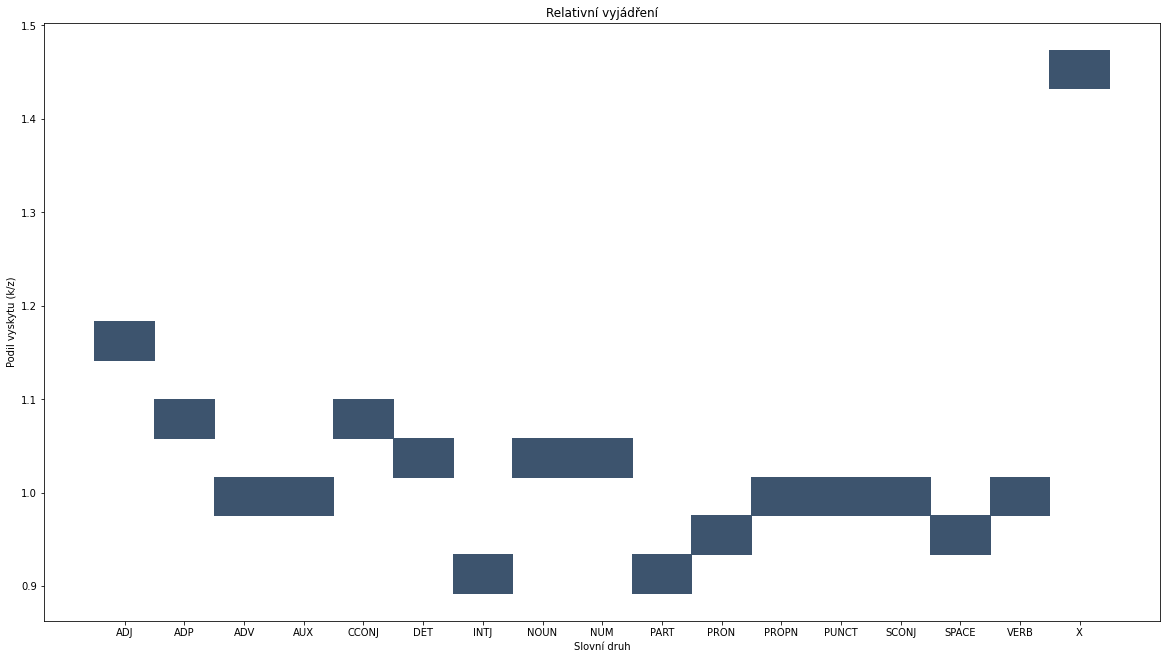

In [ ]:
f, ax = plt.subplots(figsize=(20, 11))
sns.histplot(data=slovni_druhy_final,x="Slovní druh", y="Podil vyskytu (k/z)",).set_title("Relativní vyjádření")

Text(0.5, 1.0, 'Absolutní vyjádření')

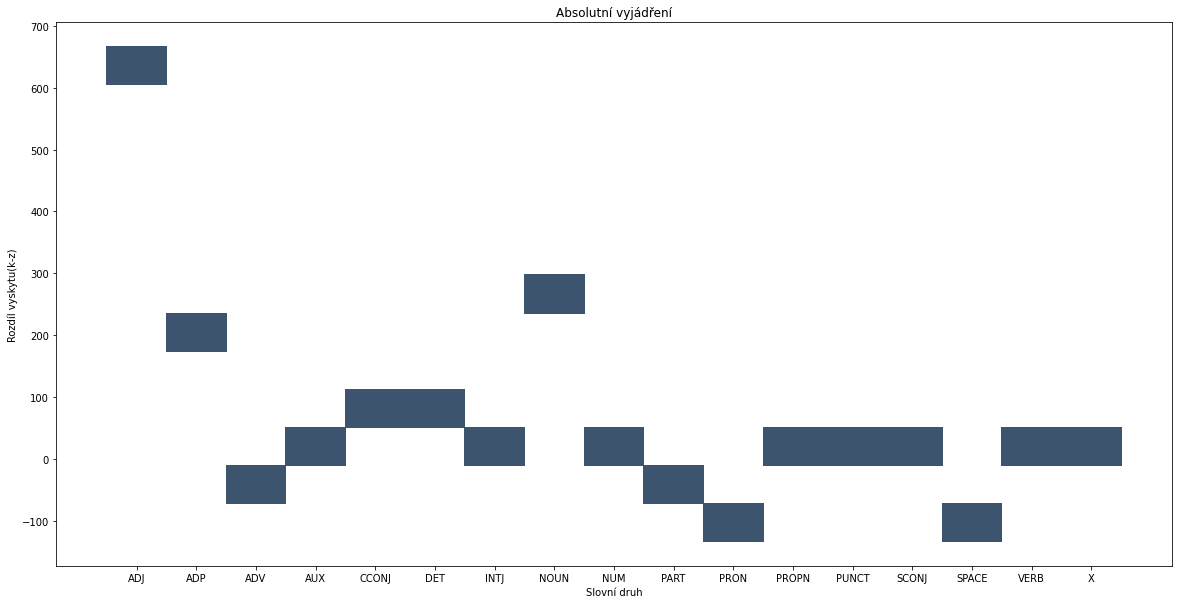

In [ ]:
f, ax = plt.subplots(figsize=(20, 10))
sns.histplot(data=slovni_druhy_final,x="Slovní druh", y="Rozdíl vyskytu(k-z)",).set_title("Absolutní vyjádření")